<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model:-Mini-VGGNet" data-toc-modified-id="Model:-Mini-VGGNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model: Mini-VGGNet</a></span></li><li><span><a href="#Implementing-the-model" data-toc-modified-id="Implementing-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementing the model</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate</a></span></li></ul></div>

In [2]:
from tensorflow.keras.datasets import fashion_mnist

# Data

Fashion MNIST:
* 60,000 training examples
* 10,000 testing examples
* 10 classes
* 28×28 grayscale images

Problems of digit MNIST:
1. It’s far too easy for standard machine learning algorithms to obtain 97%+ accuracy.
1. It’s even easier for deep learning models to achieve 99%+ accuracy.
1. The dataset is overused.
1. MNIST cannot represent modern computer vision tasks.

# Model: Mini-VGGNet

* The model is inspired by its bigger brother, VGGNet
* The model has VGGNet characteristics, including:
    * Only using 3×3 CONV filters
    * Stacking multiple CONV layers before applying a max-pooling operation

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K

In [4]:
class MiniVGGNet:
    
    @staticmethod
    def build(width, height, depth, classes):
        # The depth is the channel number
        model = Sequential()
        input_shape = (height, width, depth)
        channel_dim = -1  # where the channel DOF is, it assumes "channels_last"
        
        # make the code compatible with "channels_first" convention
        if K.image_data_format() == 'channels_first':
            input_shape = (depth, height, width)
            channel_dim = 1
            
        # First set of layers: CONV > RELU > BN > CONV > RELU > BN > POOL
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Second set of layers: CONV > RELU > BN > CONV > RELU > BN > POOL
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Set of layers: FC > RELU
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Output classifier: SOFTMAX
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

# Implementing the model

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from imutils import build_montages

import numpy as np
import cv2 as cv

In [6]:
epochs = 5
learning_rate = 0.01
batch_size = 32

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

for each in [X_train, Y_train, X_test, Y_test]:
    print(each.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [7]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else:
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

In [8]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

In [9]:
label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [10]:
# Compile
optimizer = SGD(lr=learning_rate, momentum=0.9, decay=(learning_rate/epochs))
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Train
hist = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/5


D:\Working\Anaconda\envs\basicEnv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1875/1875 [==============================] - 84s 44ms/step - loss: 0.5165 - accuracy: 0.8231 - val_loss: 0.3366 - val_accuracy: 0.8774
Epoch 2/5
1875/1875 [==============================] - 83s 44ms/step - loss: 0.3444 - accuracy: 0.8773 - val_loss: 0.2926 - val_accuracy: 0.8910
Epoch 3/5
1875/1875 [==============================] - 88s 47ms/step - loss: 0.3122 - accuracy: 0.8874 - val_loss: 0.2738 - val_accuracy: 0.8996
Epoch 4/5
1875/1875 [==============================] - 82s 44ms/step - loss: 0.2964 - accuracy: 0.8934 - val_loss: 0.2621 - val_accuracy: 0.9042
Epoch 5/5
1875/1875 [==============================] - 81s 43ms/step - loss: 0.2842 - accuracy: 0.8979 - val_loss: 0.2548 - val_accuracy: 0.9065


# Evaluate

In [11]:
Y_pred = model.predict(X_test)

In [12]:
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=label_names))

              precision    recall  f1-score   support

         top       0.87      0.82      0.85      1000
     trouser       0.99      0.97      0.98      1000
    pullover       0.86      0.87      0.86      1000
       dress       0.88      0.92      0.90      1000
        coat       0.87      0.83      0.85      1000
      sandal       0.99      0.97      0.98      1000
       shirt       0.71      0.74      0.73      1000
     sneaker       0.94      0.98      0.96      1000
         bag       0.98      0.98      0.98      1000
  ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Text(0, 0.5, 'Loss')

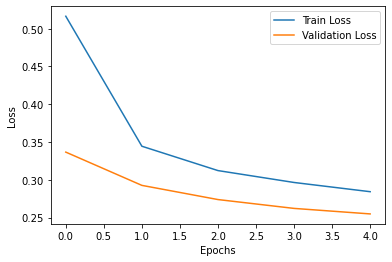

In [13]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

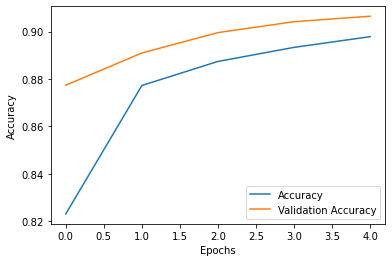

In [14]:
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

True = sneaker; Predicted = sneaker


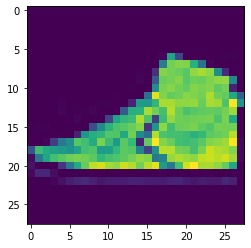

In [15]:
idx = np.random.randint(len(X_test))

true_name = label_names[Y_test[idx].argmax()]
pred_name = label_names[Y_pred[idx].argmax()]

plt.imshow(X_test[idx].reshape(28, 28))
print(f'True = {true_name}; Predicted = {pred_name}')

In [16]:
true_name = label_names[Y_test[idx].argmax()]
pred_name = label_names[Y_pred[idx].argmax()]

In [17]:
class MiniVGGNetSig:
    
    @staticmethod
    def build(width, height, depth, classes):
        # The depth is the channel number
        model = Sequential()
        input_shape = (height, width, depth)
        channel_dim = -1  # where the channel DOF is, it assumes "channels_last"
        
        # make the code compatible with "channels_first" convention
        if K.image_data_format() == 'channels_first':
            input_shape = (depth, height, width)
            channel_dim = 1
            
        # First set of layers: CONV > RELU > BN > CONV > RELU > BN > POOL
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Second set of layers: CONV > RELU > BN > CONV > RELU > BN > POOL
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # Set of layers: FC > RELU
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('sigmoid'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Output classifier: SOFTMAX
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

In [18]:
# Compile
optimizer = SGD(lr=learning_rate, momentum=0.9, decay=(learning_rate/epochs))
model = MiniVGGNetSig.build(width=28, height=28, depth=1, classes=10)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Train
hist = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/5


D:\Working\Anaconda\envs\basicEnv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1875/1875 [==============================] - 84s 44ms/step - loss: 0.4985 - accuracy: 0.8274 - val_loss: 0.3012 - val_accuracy: 0.8876
Epoch 2/5
1875/1875 [==============================] - 81s 43ms/step - loss: 0.3306 - accuracy: 0.8816 - val_loss: 0.2823 - val_accuracy: 0.8985
Epoch 3/5
1875/1875 [==============================] - 81s 43ms/step - loss: 0.3023 - accuracy: 0.8906 - val_loss: 0.2596 - val_accuracy: 0.9063
Epoch 4/5
1875/1875 [==============================] - 81s 43ms/step - loss: 0.2849 - accuracy: 0.8959 - val_loss: 0.2593 - val_accuracy: 0.9031
Epoch 5/5
1875/1875 [==============================] - 81s 43ms/step - loss: 0.2739 - accuracy: 0.8999 - val_loss: 0.2410 - val_accuracy: 0.9128


In [19]:
Y_pred = model.predict(X_test)

In [20]:
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=label_names))

              precision    recall  f1-score   support

         top       0.86      0.87      0.87      1000
     trouser       1.00      0.97      0.99      1000
    pullover       0.87      0.86      0.87      1000
       dress       0.90      0.92      0.91      1000
        coat       0.83      0.89      0.86      1000
      sandal       0.99      0.98      0.98      1000
       shirt       0.77      0.72      0.74      1000
     sneaker       0.95      0.98      0.97      1000
         bag       0.99      0.98      0.98      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Text(0, 0.5, 'Loss')

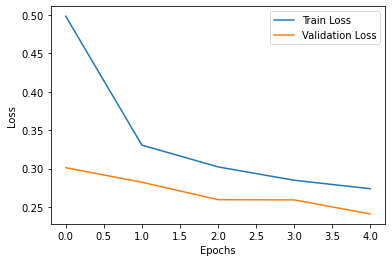

In [21]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

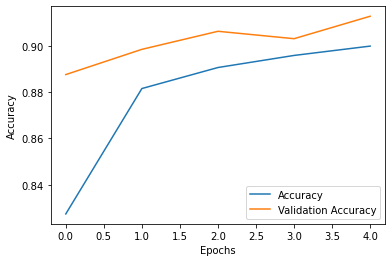

In [22]:
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')